In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import yfinance as yf
start_date = '2020-01-01'
end_date = '2023-03-15'
ticker = 'UBS'
df = yf.download(ticker, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [2]:
df1 = df['Close']

In [3]:
df1

Date
2020-01-02    12.920000
2020-01-03    12.710000
2020-01-06    12.680000
2020-01-07    12.940000
2020-01-08    13.110000
                ...    
2023-03-08    21.389999
2023-03-09    20.930000
2023-03-10    20.340000
2023-03-13    19.360001
2023-03-14    19.990000
Name: Close, Length: 805, dtype: float64

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,12.70,12.920,12.670,12.92,11.247201,3352200
2020-01-03,12.68,12.770,12.650,12.71,11.064390,2627400
2020-01-06,12.60,12.700,12.580,12.68,11.038276,2318500
2020-01-07,12.92,12.985,12.863,12.94,11.264612,4237600
2020-01-08,13.07,13.150,13.050,13.11,11.412601,3363200


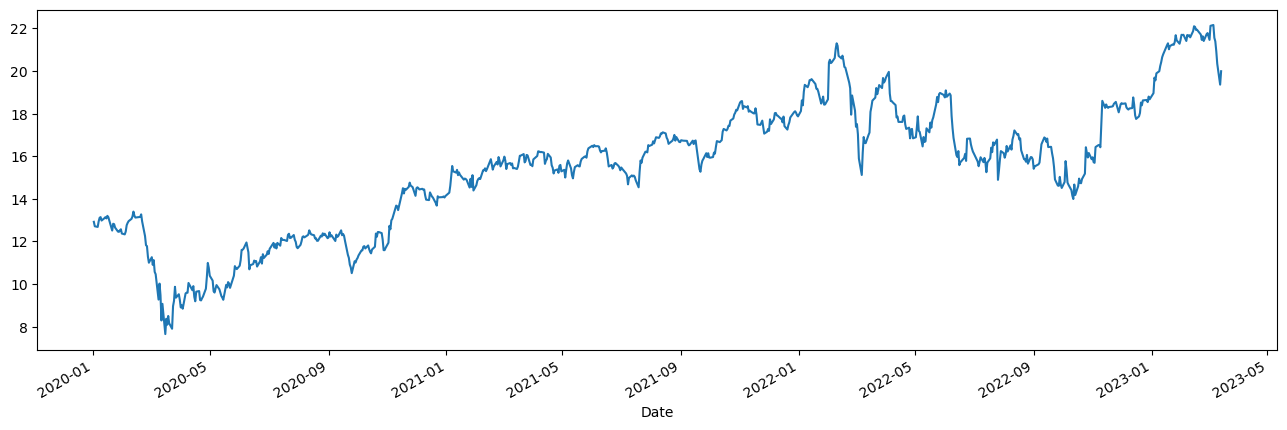

In [8]:
ax = df['Close'].plot(figsize=(16,5))
ax.autoscale(axis='Date',tight=True)

In [9]:
df1 = df1.asfreq('D')
df1

Date
2020-01-02    12.920000
2020-01-03    12.710000
2020-01-04          NaN
2020-01-05          NaN
2020-01-06    12.680000
                ...    
2023-03-10    20.340000
2023-03-11          NaN
2023-03-12          NaN
2023-03-13    19.360001
2023-03-14    19.990000
Freq: D, Name: Close, Length: 1168, dtype: float64

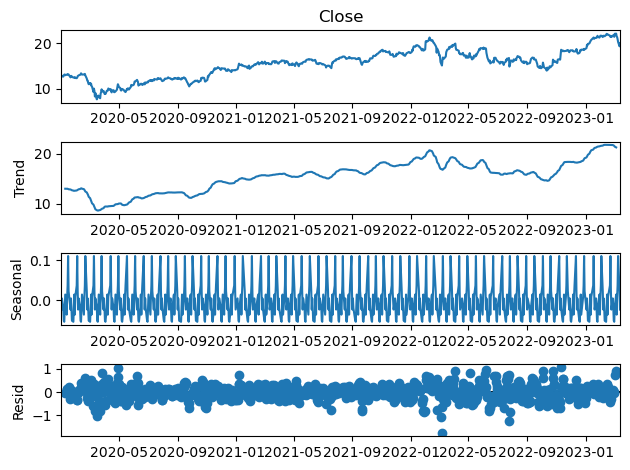

In [10]:
seasonal_decompose(df1[pd.isnull(df1)==False],period=12).plot();

<AxesSubplot:xlabel='Date'>

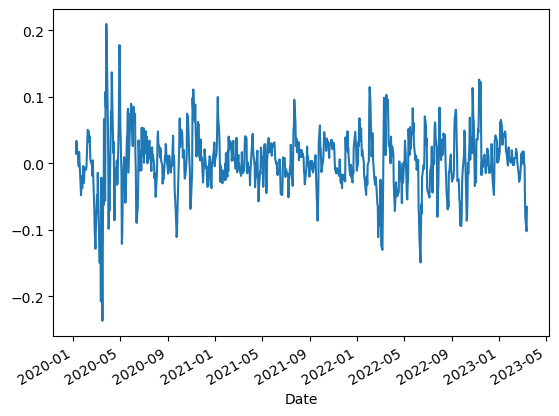

In [22]:
df4 = df['Close'].pct_change(4)
df4.plot()

In [51]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot

In [77]:
df4.tail(10).values

array([[-0.00092457],
       [ 0.00233532],
       [ 0.0179476 ],
       [ 0.01744716],
       [-0.0023138 ],
       [-0.00326187],
       [-0.05379749],
       [-0.08212995],
       [-0.10204077],
       [-0.06545113]])

In [228]:
def transform_data_into_series(data = df4, n_in=12, n_out=6, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    #X = agg.values[:, :-3]
    #y = agg.values[:, 3:]
    
    # .values - switch from DataFrame into array
    return agg.values

In [231]:
# split a univariate dataset into train/test sets
# 1 -> the last period as testing set
def train_test_split(data, n_test=1):
    return data[:-n_test, :], data[-n_test:, :]

In [232]:
def split_into_X_y(train, test, n_in=12, n_out=6):
    X_train = train[:, :-n_out]
    y_train = train[:, n_in:]
    X_test = test[:, :-n_out]
    y_test = test[:, n_in:]
    return X_train, y_train, X_test, y_test

In [233]:
series = transform_data_into_series()
train, test = train_test_split(series)
X_train, y_train, X_test, y_test = split_into_X_y(train, test)

In [202]:
X_train[0]

array([ 0.01470585,  0.03383165,  0.02365925,  0.01159201,  0.00228838,
       -0.00456624,  0.01694917,  0.00381972, -0.04794521, -0.01911315,
       -0.02954541, -0.03729077])

In [203]:
y_train[0]

array([-0.00399682, -0.02961809, -0.02263856, -0.0063241 , -0.00722313,
       -0.00963855])

In [186]:
series[0]

array([ 0.01470585,  0.03383165,  0.02365925,  0.01159201,  0.00228838,
       -0.00456624,  0.01694917,  0.00381972, -0.04794521, -0.01911315,
       -0.02954541, -0.03729077, -0.00399682, -0.02961809, -0.02263856,
       -0.0063241 , -0.00722313, -0.00963855])

In [204]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [205]:
yhat = model.predict(X_test)

In [206]:
yhat[0]

array([ 0.03587048,  0.04899145,  0.03392247,  0.00727989, -0.0179867 ,
       -0.01489781], dtype=float32)

In [207]:
X_test

array([[ 0.01621874,  0.00320072, -0.01764712, -0.02763936, -0.01367994,
        -0.02415682,  0.00092126,  0.01491154, -0.00092457,  0.00233532,
         0.0179476 ,  0.01744716]])

In [208]:
y_test

array([[-0.0023138 , -0.00326187, -0.05379749, -0.08212995, -0.10204077,
        -0.06545113]])

In [209]:
series[-1:][0]

array([ 0.01621874,  0.00320072, -0.01764712, -0.02763936, -0.01367994,
       -0.02415682,  0.00092126,  0.01491154, -0.00092457,  0.00233532,
        0.0179476 ,  0.01744716, -0.0023138 , -0.00326187, -0.05379749,
       -0.08212995, -0.10204077, -0.06545113])

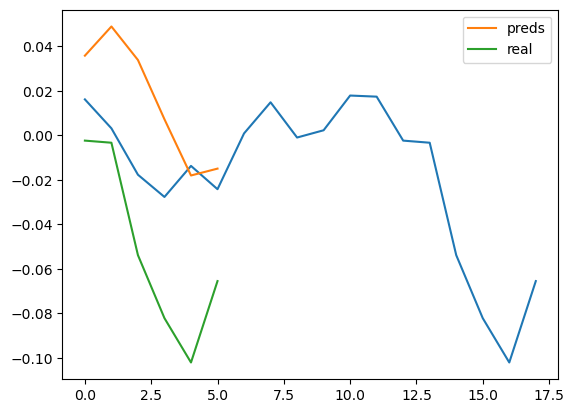

In [234]:
pyplot.plot(series[-1:][0])
pyplot.plot(yhat[0],label='preds')
pyplot.plot(y_test[0],label='real')
pyplot.legend()
pyplot.show()

In [256]:
X_train[-1]

array([ 0.0179889 ,  0.01621874,  0.00320072, -0.01764712, -0.02763936,
       -0.01367994, -0.02415682,  0.00092126,  0.01491154, -0.00092457,
        0.00233532,  0.0179476 ])

In [268]:
df4.tail(8)

,Close
Date,
2023-03-03,0.017948
2023-03-06,0.017447
2023-03-07,-0.002314
2023-03-08,-0.003262
2023-03-09,-0.053797
2023-03-10,-0.082130
2023-03-13,-0.102041
2023-03-14,-0.065451


In [265]:
y_test

array([[-0.0023138 , -0.00326187, -0.05379749, -0.08212995, -0.10204077,
        -0.06545113]])

In [278]:
X_test[0][-2:]

array([0.0179476 , 0.01744716])

In [272]:
df.index[-12:]

DatetimeIndex(['2023-02-27', '2023-02-28', '2023-03-01', '2023-03-02',
               '2023-03-03', '2023-03-06', '2023-03-07', '2023-03-08',
               '2023-03-09', '2023-03-10', '2023-03-13', '2023-03-14'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [283]:
str(df.index[-1].date())

'2023-03-14'

## Forecasting 

<AxesSubplot:xlabel='Date'>

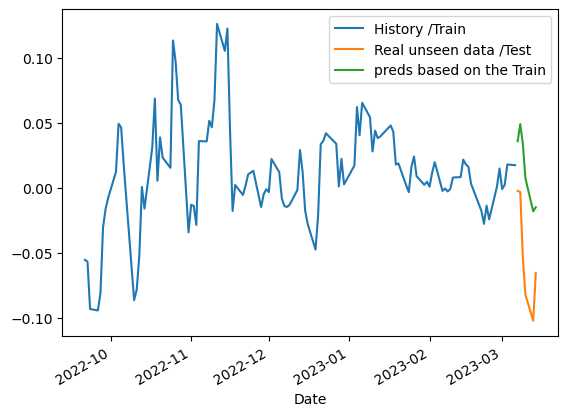

In [338]:
# n_out=6
ax = df4.iloc[-120:-6,:].rename(columns={'Close':'History /Train'}).plot()
df4.iloc[-6:,:].rename(columns={'Close':'Real unseen data /Test'}).plot(ax=ax)
pd.DataFrame({'preds based on the Train': yhat[0]}, index=df4.iloc[-6:,:].index).plot(ax=ax)
#index=pd.date_range(start=str((df.index[-1]).date()+pd.DateOffset(days=1)),periods=6)).plot(ax=ax,label='true',legend=True)
